In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

import sys
sys.path.append('..')
from config.config import TICKERS, RAW_DATA_PATH, PROCESSED_DATA_PATH

In [2]:
stock_data = {}

for ticker in TICKERS:
    filepath = f"{RAW_DATA_PATH}{ticker}.csv"
    try:
        df = pd.read_csv(filepath, parse_dates=['Date'])
        stock_data[ticker] = df
        print(f"✓ Loaded {ticker}: {df.shape[0]} rows, {df.shape[1]} columns")
    except FileNotFoundError:
        print(f"✗ ERROR: File not found for {ticker}")
    except Exception as e:
        print(f"✗ ERROR loading {ticker}: {e}")

print(f"\nTotal stocks loaded: {len(stock_data)}")

✓ Loaded PG: 1254 rows, 6 columns
✓ Loaded KO: 1254 rows, 6 columns
✓ Loaded WMT: 1254 rows, 6 columns
✓ Loaded COST: 1254 rows, 6 columns
✓ Loaded JNJ: 1254 rows, 6 columns
✓ Loaded UNH: 1254 rows, 6 columns
✓ Loaded PFE: 1254 rows, 6 columns
✓ Loaded MRK: 1254 rows, 6 columns

Total stocks loaded: 8


In [3]:
stock_df = pd.concat(
    stock_data,
    names=["Ticker", "Row"]
).reset_index(level=0)
stock_df.head()

df_clean = stock_df.copy()

In [4]:
print("Missing Values: ", df_clean.isna().sum())

df_clean = df_clean.sort_values('Date').reset_index(drop=True)

print("Shape: ", df_clean.shape)
df_clean.head(10)


Missing Values:  Ticker    0
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Shape:  (10032, 7)


,Ticker,Date,Open,High,Low,Close,Volume
0,PG,2021-01-19 00:00:00-05:00,119.742797,120.325190,117.854444,117.889748,9184900
1,KO,2021-01-19 00:00:00-05:00,41.933360,42.191464,41.503186,41.735477,29114500
2,MRK,2021-01-19 00:00:00-05:00,68.037590,68.306258,67.296727,67.728218,8467316
3,WMT,2021-01-19 00:00:00-05:00,45.045907,45.179824,44.432381,44.656612,24123600
4,PFE,2021-01-19 00:00:00-05:00,28.803764,28.991820,28.694066,28.780258,33451300
5,UNH,2021-01-19 00:00:00-05:00,328.332176,329.023479,324.046101,324.626801,3361300
6,JNJ,2021-01-19 00:00:00-05:00,140.549417,141.451704,139.768592,141.226135,9057600
7,COST,2021-01-19 00:00:00-05:00,342.856024,343.414292,333.469982,335.390717,4533800
8,MRK,2021-01-20 00:00:00-05:00,67.777056,68.021300,66.979202,67.133888,11097901
9,COST,2021-01-20 00:00:00-05:00,335.315073,342.420830,334.387811,341.853119,2767200


In [11]:
def clean_data(df, ticker):
    df = df.drop_duplicates().reset_index(drop=True)

    missing_count = df.isna().sum().sum()
    if missing_count > 0:
        print(f"{ticker}: Found {missing_count} missing values")
        df = df.fillna(method="ffill", limit=3)
        df = df.dropna()

    price_cols = ["Open", "High", "Low", "Close"]
    for col in price_cols:
        if (df[col] <= 0).any():
            print(f"{ticker}: WARNING - Found non-positive prices in {col}")
            df = df[df[col] > 0]

    return df



In [12]:
Path(PROCESSED_DATA_PATH).mkdir(parents=True, exist_ok=True)

cleaned_data = {}

for ticker, df_ticker in df_clean.groupby("Ticker"):
    cleaned_df = clean_data(df_ticker, ticker)
    cleaned_data[ticker] = cleaned_df

    filepath = f"{PROCESSED_DATA_PATH}/{ticker}_clean.csv"
    cleaned_df.to_csv(filepath, index=False)
    print(f"Saved {ticker} to {filepath}")

Saved COST to ../data/processed//COST_clean.csv
Saved JNJ to ../data/processed//JNJ_clean.csv
Saved KO to ../data/processed//KO_clean.csv
Saved MRK to ../data/processed//MRK_clean.csv
Saved PFE to ../data/processed//PFE_clean.csv
Saved PG to ../data/processed//PG_clean.csv
Saved UNH to ../data/processed//UNH_clean.csv
Saved WMT to ../data/processed//WMT_clean.csv


In [18]:
returns_data = {}

def add_returns(df):
    df = df.sort_values('Date').copy()
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["simple_return"] = df["Close"].pct_change()
    return df.dropna()

def add_volatility(df, window=20):
    df["rolling_vol_20d"] = df["simple_return"].rolling(window).std() * np.sqrt(252)
    return df

for ticker in cleaned_data:
    cleaned_data[ticker] = add_returns(cleaned_data[ticker])
    cleaned_data[ticker] = add_volatility(cleaned_data[ticker])


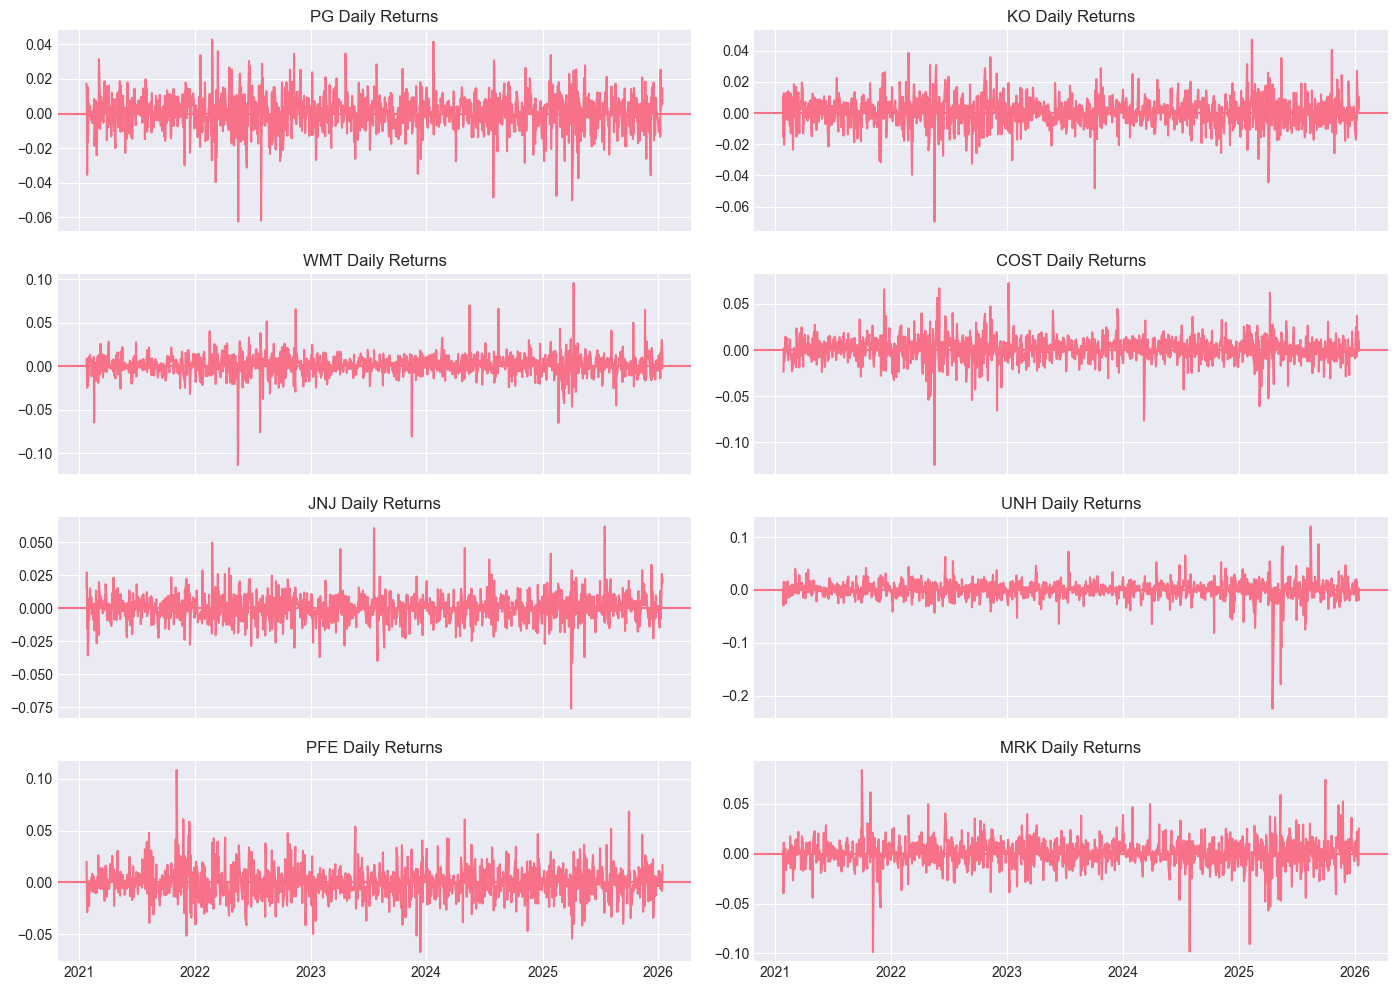

In [19]:
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

for i, ticker in enumerate(TICKERS):
    df = cleaned_data[ticker]
    axes[i].plot(df["Date"], df["simple_return"])
    axes[i].axhline(0)
    axes[i].set_title(f"{ticker} Daily Returns")

plt.tight_layout()
plt.show()

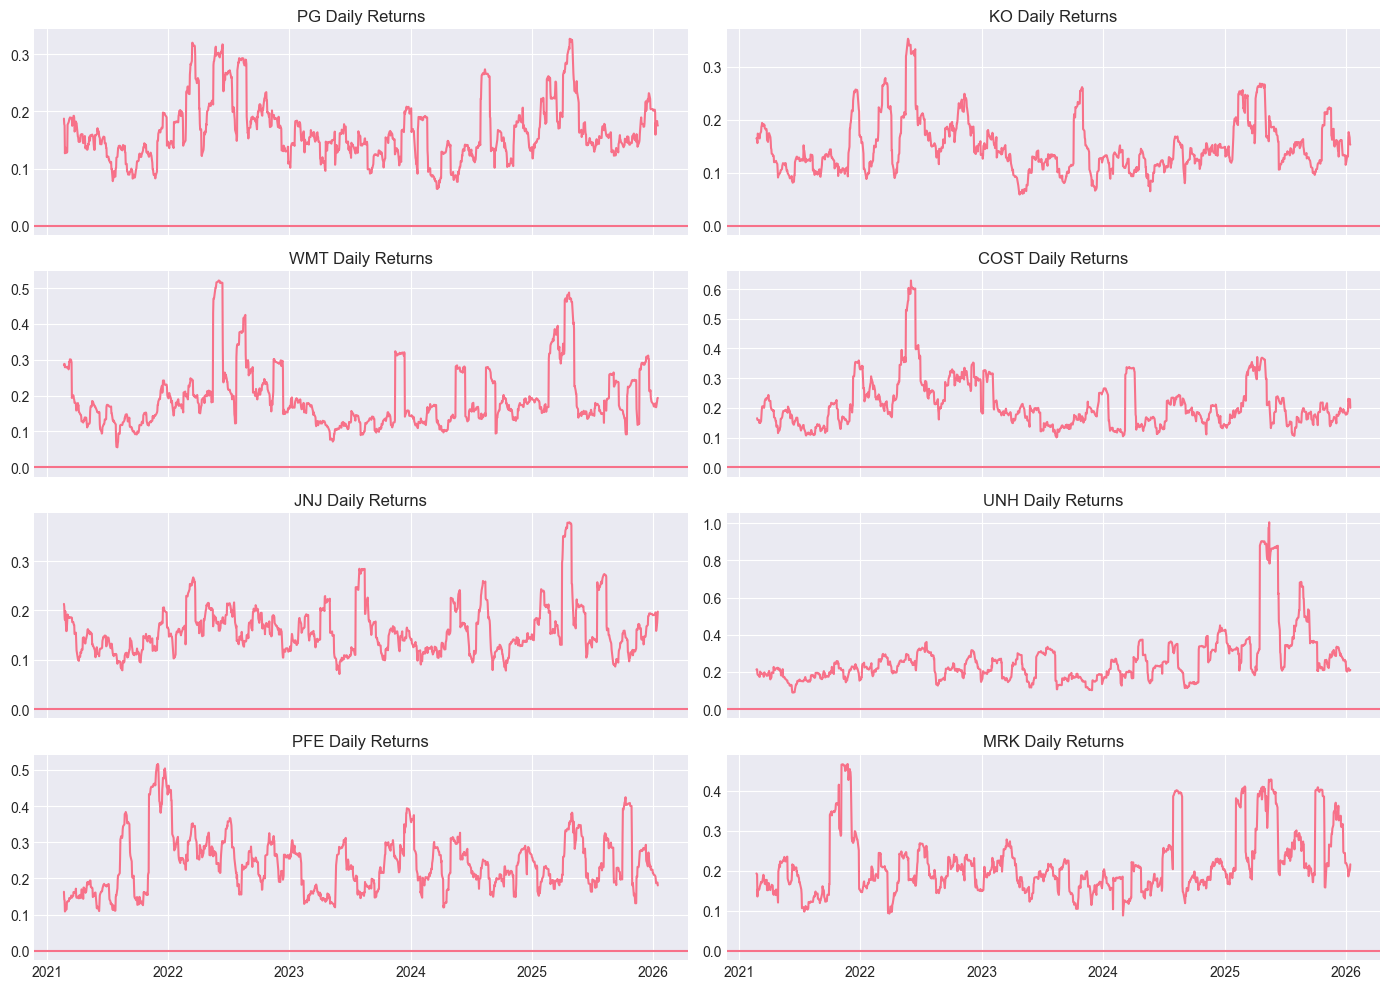

In [20]:
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

for i, ticker in enumerate(TICKERS):
    df = cleaned_data[ticker]
    axes[i].plot(df["Date"], df["rolling_vol_20d"])
    axes[i].axhline(0)
    axes[i].set_title(f"{ticker} Daily Returns")

plt.tight_layout()
plt.show()